[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/ddpm/ddpm_cnn.ipynb)

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Dataset**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
# transforms = torchvision.transforms.Compose([
#       torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
#       torchvision.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
#       torchvision.transforms.ToTensor(),
#       torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#   ])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=4) # loading the downloaded dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15975057.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481283.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4458203.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4722491.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Modelling**

In [ ]:
!git clone https://github.com/khetansarvesh/CV.git
from CV.representation_learning.residual_block_utils import ResidualBlock

Cloning into 'CV'...
remote: Enumerating objects: 750, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 750 (delta 116), reused 58 (delta 29), pack-reused 534
Receiving objects: 100% (750/750), 27.56 MiB | 43.97 MiB/s, done.
Resolving deltas: 100% (413/413), done.


In [ ]:
def get_time_embedding(time_steps, # 1D array of timesteps eg [1,10,500,40,300]
                       temb_dim): # dimension of vector to which each of these timestep needs to be converted to eg 128

    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2)))

    # pos / factor
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor

    # now taking sin and cos of t_emb
    return torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)

In [ ]:
class Unet(nn.Module):

    def __init__(self):
        super().__init__()

        '''encoder'''
        self.en_1 = nn.Conv2d(1, 32, kernel_size=3, padding=(1, 1))
        self.ti_1 = nn.Linear(128, 32)
        self.en_2 = ResidualBlock(32, 128, norm_num_groups = 8)
        self.en_3 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1)
        self.en_4 = ResidualBlock(128, 256, norm_num_groups = 8)

        '''mid block'''
        self.mid_layer_1 = ResidualBlock(256,256, norm_num_groups=8)
        self.mid_layer_2 = ResidualBlock(256,128, norm_num_groups=8)

        '''decoder'''
        self.de_2 = ResidualBlock(256, 32, norm_num_groups=8)
        self.de_3 = nn.ConvTranspose2d(32, 32,kernel_size=4, stride=2, padding=1)
        self.de_4 = ResidualBlock(64, 16, norm_num_groups=8)
        self.de_5 = nn.Sequential(nn.GroupNorm(8, 16), nn.SiLU(), nn.Conv2d(16, 1, kernel_size=3, padding=1))

    def forward(self, x, t):

        down_outs = []

        t_emb = get_time_embedding(torch.as_tensor(t).long(), 128)

        # encoder
        out = self.en_1(x) + self.ti_1(t_emb)[:, :, None, None]
        down_outs.append(out)
        out = self.en_2(out)
        out = self.en_3(out) + t_emb[:, :, None, None]
        down_outs.append(out)
        out = self.en_4(out)

        # middle block
        out = self.mid_layer_1(out)
        out = self.mid_layer_2(out)

        # decoder
        down_out = down_outs.pop()
        out = torch.cat([out, down_out], dim=1)
        out = self.de_2(out)
        out = self.de_3(out) + self.ti_1(t_emb)[:, :, None, None]
        down_out = down_outs.pop()
        out = torch.cat([out, down_out], dim=1)
        out = self.de_4(out)
        out = self.de_5(out)

        return out

# **Training**

In [ ]:
batch_size = 64
num_samples = 100
num_grid_rows = 10

model = Unet().to(device)
model.train()
optimizer = Adam(model.parameters(), lr = 0.0001)

betas = torch.linspace(0.0001, 0.02, 1000).to(device) # creating a linear beta schedule for all the timestamps
alpha_cum_prod = torch.cumprod(1. - betas, dim=0).to(device) # calculating alpha_bar for each timestamp
sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod).to(device) # calculating sqrt(alpha_bar) for each timestamp
sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod).to(device) # calculating sqrt(1-alpha_bar) for each timestamp

In [ ]:
for epoch in range(20): # running for 40 epochs
  losses = []
  for im,_ in tqdm(mnist_loader):
    optimizer.zero_grad()

    im = im.float().to(device)
    noise = torch.randn_like(im).to(device) # sample random noise
    t = torch.randint(low = 0, high = 1000, size = (im.shape[0],)).to(device) # sample a random timestamp for each image in the batch
    noisy_im = torch.sqrt(alpha_cum_prod[t])[:, None, None, None].to(device) * im + torch.sqrt(1 - alpha_cum_prod[t])[:, None, None, None].to(device) * noise # add noise to image according to the timestamp
    noise_pred = model(noisy_im, t) # predicting the added noise

    loss = torch.nn.MSELoss()(noise_pred, noise) # loss fucntion
    losses.append(loss.item())
    loss.backward() # backpropagating the loss
    optimizer.step()
  print()

  0%|          | 0/938 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 938/938 [01:18<00:00, 11.98it/s]


100%|██████████| 938/938 [01:16<00:00, 12.34it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.28it/s]


100%|██████████| 938/938 [01:16<00:00, 12.28it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.33it/s]


100%|██████████| 938/938 [01:16<00:00, 12.31it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.32it/s]


100%|██████████| 938/938 [01:16<00:00, 12.31it/s]


100%|██████████| 938/938 [01:16<00:00, 12.29it/s]


100%|██████████| 938/938 [01:16<00:00, 12.31it/s]


100%|██████████| 938/938 [01:16<00:00, 12.31it/s]


100%|██████████| 938/938 [01:16<00:00, 12.30it/s]


100%|██████████| 938/938 [01:16<00:00, 12.32it/s]


100%|██████████| 938/938 [01:16<00:00, 12.33it/s]


100%|██████████| 938/938 [01:16<00:00, 12.31it/s]

# **Inference**

In [ ]:
model.eval()
batch_size = 64
num_epochs = 40
num_samples = 100
num_grid_rows = 10
im_channels = 1
im_size = 28

In [ ]:
with torch.no_grad():
    # creating a random noise sample based on number of images requested to generate
    xt = torch.randn((num_samples, im_channels, im_size, im_size)).to(device)
    for i in tqdm(reversed(range(1000))):

        t = torch.as_tensor(i)
        noise_pred = model(xt, t.unsqueeze(0).to(device)) # Get prediction of noise

        # timestep
        t = t.to(device)

        # calculating Xt-1 using the derived formula
        mean = (xt - ((betas[t])*noise_pred)/(sqrt_one_minus_alpha_cum_prod[t])) / torch.sqrt(1. - betas[t])
        variance = ( (1-alpha_cum_prod[t-1]) / (1.0 - alpha_cum_prod[t]) ) * betas[t]
        sigma = variance ** 0.5 if t != 0 else 0
        xt = mean + sigma * torch.randn(xt.shape).to(xt.device)

        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = 0.5*ims + 0.5
        grid = make_grid(ims, nrow= num_grid_rows)

        # predicted image
        img = torchvision.transforms.ToPILImage()(grid)

1000it [00:49, 20.37it/s]


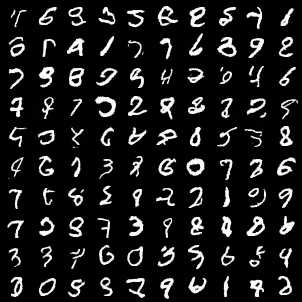

In [ ]:
img